# Using the Sample Representation Method GloScope

In this tutorial, we will demostrate how to use the reimplemented version of GloScope in `patpy` to build a sample representation from single-cell transcriptomics data.

## 1. Setup

### 1.1 Install the patpy package

This package contains the interface to sample representation methods as well as some handy analysis functions.

In [133]:
#!pip install git+https://github.com/lueckenlab/patpy.git@main

### 1.2 Import packages

In [ ]:
import pandas as pd
import numpy as np
import scanpy as sc
import patpy
import seaborn as sns
import matplotlib.pyplot as plt

In [135]:
patpy.__version__

'0.9.2'

## 2. Data Preparation

### 2.1 Read the data

Here, we use [COMBAT dataset](https://www.kaggle.com/datasets/shitovvladimir/a-blood-atlas-of-covid-19-combat-preprocessed). This dataset contains 783k cells from 140 COVID-19 patients and healthy donors.

In [136]:
ADATA_PATH = "/Users/emmaschonner/PycharmProjects/patpy_atlassing/_data-gitignore/combat_processed.h5ad"

In [137]:
adata = sc.read_h5ad(ADATA_PATH)
adata

AnnData object with n_obs × n_vars = 783704 × 3000
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_HC

### 2.2 Set columns containing sample IDs, cell types and metadata

In [138]:
sample_id_col = "scRNASeq_sample_ID"
cell_type_key = "cell_type"
samples_metadata_cols = ["Source", "Outcome", "Death28", "Hospitalstay", "TimeSinceOnset", "Institute", "Pool_ID", 
                         "Age", "Sex", "BMI", "PreExistingHeartDisease", "PreExistingLungDisease", "PreExistingDiabetes",
                         "PreExistingHypertension", "Smoking", "Requiredvasoactive", "SARSCoV2PCR"]

samples_metadata_cols_plot = ["Source", "Outcome", "Death28", "Institute", "Pool_ID"]

Currently, there is no such columns as “cell_type” in the data. But cell types are stored in the `Annotation_major_subset` column. Let’s rename it to `cell_type` for better readability.

In [139]:
adata.obs.rename(columns={"Annotation_major_subset": cell_type_key}, inplace=True)

### 2.3 Store metadata and calculate QC metrics

In [153]:
metadata = adata.obs[samples_metadata_cols + [sample_id_col]].drop_duplicates()
metadata.set_index(sample_id_col, inplace=True)
metadata

,Source,Outcome,Death28,Hospitalstay,TimeSinceOnset,Institute,Pool_ID,Age,Sex,BMI,PreExistingHeartDisease,PreExistingLungDisease,PreExistingDiabetes,PreExistingHypertension,Smoking,Requiredvasoactive,SARSCoV2PCR
scRNASeq_sample_ID,,,,,,,,,,,,,,,,,
S00109-Ja001E-PBCa,COVID_SEV,2.0,0,1.0,12.0,Oxford,gPlexA,5.0,1,5,0.0,0.0,0.0,1.0,0,1.0,1
S00112-Ja003E-PBCa,COVID_MILD,5.0,0,2.0,12.0,Oxford,gPlexA,5.0,1,5,0.0,0.0,0.0,0.0,0,0.0,1
S00005-Ja005E-PBCa,COVID_CRIT,2.0,0,4.0,14.0,Oxford,gPlexA,7.0,0,1,1.0,0.0,0.0,1.0,0,1.0,1
S00061-Ja003E-PBCa,COVID_SEV,4.0,0,2.0,6.0,Oxford,gPlexA,5.0,1,5,0.0,0.0,0.0,0.0,0,0.0,1
S00056-Ja003E-PBCa,COVID_SEV,3.0,0,3.0,23.0,Oxford,gPlexA,7.0,0,5,0.0,0.0,0.0,0.0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S00065-Ja003E-PBCa,COVID_CRIT,2.0,0,3.0,16.0,Oxford,gPlexK,5.0,0,5,0.0,0.0,1.0,0.0,0,1.0,1
S00048-Ja003E-PBCa,COVID_SEV,4.0,0,2.0,12.0,Oxford,gPlexK,7.0,1,3,0.0,0.0,0.0,1.0,0,0.0,1
G05112-Ja005E-PBCa,COVID_HCW_MILD,6.0,0,NaN,7.0,Oxford,gPlexK,4.0,0,5,NaN,NaN,NaN,NaN,0,NaN,1


In [154]:
cell_qc_metadata = patpy.pp.calculate_cell_qc_metrics(
    adata, sample_key=sample_id_col, cell_qc_vars=["QC_ngenes", "QC_total_UMI", "QC_pct_mitochondrial"]
)
cell_qc_metadata.columns = ["median_n_genes_by_counts", "median_total_counts", "median_pct_counts_mt"]
cell_qc_metadata

,median_n_genes_by_counts,median_total_counts,median_pct_counts_mt
scRNASeq_sample_ID,,,
G05061-Ja005E-PBCa,1107.0,3125.5,3.011159
G05064-Ja005E-PBCa,975.0,2933.0,1.332430
G05073-Ja005E-PBCa,1141.0,3554.0,2.422559
G05077-Ja005E-PBCa,1125.0,3268.0,2.946723
G05078-Ja005E-PBCa,999.0,3106.0,2.825308
...,...,...,...
U00607-Ua005E-PBUa,1827.0,5749.0,2.982509
U00613-Ua005E-PBUa,1251.5,3325.0,2.053083
U00617-Ua005E-PBUa,1410.5,4524.0,3.886215


In [155]:
n_genes_metadata = patpy.pp.calculate_n_cells_per_sample(adata, sample_id_col)
n_genes_metadata

,n_cells
scRNASeq_sample_ID,
S00052-Ja005E-PBCa,13918
H00054-Ha001E-PBGa,10938
H00067-Ha001E-PBGa,10781
N00023-Ja001E-PBGa,10484
H00053-Ha001E-PBGa,10458
...,...
U00701-Ua005E-PBUa,872
U00601-Ua005E-PBUa,619
U00504-Ua005E-PBUa,161


In [156]:
composition_metadata = patpy.pp.calculate_compositional_metrics(adata, sample_id_col, [cell_type_key], normalize_to=100)
composition_metadata

cell_type,cell_type_B,cell_type_CD4,cell_type_CD8,cell_type_DC,cell_type_DN,cell_type_DP,cell_type_GDT,cell_type_HSC,cell_type_MAIT,cell_type_Mast,cell_type_NK,cell_type_PB,cell_type_PLT,cell_type_RET,cell_type_cMono,cell_type_iNKT,cell_type_ncMono
scRNASeq_sample_ID,,,,,,,,,,,,,,,,,
G05061-Ja005E-PBCa,6.324900,33.921438,12.366844,1.597870,0.532623,0.499334,0.898802,0.066578,4.677097,0.000000,18.159121,0.316245,0.166445,0.016644,15.812250,0.033289,4.610519
G05064-Ja005E-PBCa,3.405158,47.147482,16.400581,1.819806,1.228090,0.725689,2.188233,0.022329,1.317405,0.000000,7.457854,0.446578,0.000000,0.000000,14.357486,0.000000,3.483309
G05073-Ja005E-PBCa,5.194338,45.609405,16.278791,1.487524,1.247601,0.839731,4.654511,0.011996,2.195298,0.011996,3.730806,0.203935,0.047985,0.000000,13.963532,0.083973,4.438580
G05077-Ja005E-PBCa,5.846211,29.231056,14.596909,1.377770,0.446844,1.340532,0.465463,0.167567,0.800596,0.018619,22.844908,1.079873,0.074474,0.018619,18.004096,0.055856,3.630609
G05078-Ja005E-PBCa,1.366381,39.000106,15.591569,2.340854,0.762631,0.730855,2.648025,0.211842,1.737104,0.021184,10.666243,0.148289,0.021184,0.000000,19.521237,0.497829,4.734668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U00607-Ua005E-PBUa,3.623898,10.577865,1.273262,4.701273,0.097943,0.195886,0.195886,0.685602,0.097943,0.000000,5.876592,1.175318,1.958864,0.097943,37.904016,0.000000,31.537708
U00613-Ua005E-PBUa,7.835052,26.391753,16.907216,0.721649,0.412371,0.309278,1.649485,0.000000,0.103093,0.000000,5.154639,1.237113,0.206186,0.000000,37.938144,0.000000,1.134021
U00617-Ua005E-PBUa,2.977233,41.418564,16.462347,0.437828,0.525394,0.262697,0.262697,0.963222,0.087566,0.000000,7.530648,17.513135,0.788091,0.087566,9.719790,0.000000,0.963222


Add the additional meta data to the AnnData object:

In [ ]:
metadata = pd.concat(
    [
        metadata,
        cell_qc_metadata.loc[metadata.index],
        n_genes_metadata.loc[metadata.index],
        composition_metadata.loc[metadata.index],
    ],
    axis=1,
)

metadata.shape

(140, 38)

### 2.4 Quality control

To reduce noise in the representations, we need to remove samples with too few cells:

In [ ]:
adata = patpy.pp.filter_small_samples(adata, sample_key=sample_id_col, sample_size_threshold=100)

2 samples removed: G05092-Ja005E-PBCa, S00030-Ja003E-PBCa


KeyboardInterrupt: 

## 3. Original GloScope Implementation

This version is [implemented in R](https://www.bioconductor.org/packages/release/bioc/html/GloScope.html) and can be used via patpy.

### 3.1 Prepare a smaller data set

The COMBAT data set consists of 140 samples (138 after quality control) and 783.704 cells. This subset is equivalent to ~8% of the original data set.

In [114]:
np.random.seed(42)

# Choose 10 random samples from the AnnData object
random_samples = np.random.choice(adata.obs['scRNASeq_sample_ID'].unique(), size=10, replace=False)

# Create subset using the random samples
adata_subset = adata[adata.obs['scRNASeq_sample_ID'].isin(random_samples)].copy()
adata_subset

AnnData object with n_obs × n_vars = 59868 × 3000
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'cell_type', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_HC', 'BCR_functio

### 3.2 Run the GloScope representation

In [9]:
gloscope_r = patpy.tl.GloScope(sample_key=sample_id_col, layer="X_pca", k=25)
gloscope_r.prepare_anndata(adata_subset)

Error importing in API mode: ImportError("dlopen(/Users/emmaschonner/miniforge3/envs/gloscope/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): symbol not found in flat namespace '_R_BaseEnv'")
Trying to import in ABI mode.


### 3.3 Calculate the distance matrix between samples

In [ ]:
import time

t_start = time.time()
distances_r = gloscope_r.calculate_distance_matrix(force=True)
t_end = time.time()

distances_r

Calculating GloScope distance matrix


,G05064-Ja005E-PBCa,N00024-Ja001E-PBGa,U00605-Ua005E-PBUa,N00047-Ja005E-PBGa,S00095-Ja005E-PBCa,H00072-Ha001E-PBGa,S00049-Ja003E-PBCa,G05105-Ja005E-PBCa,S00054-Ja001E-PBCa,N00013-Ja005E-PBGa
G05064-Ja005E-PBCa,0.000000,21.799740,55.601778,23.112455,18.857918,24.209632,21.663547,15.027590,29.691301,22.898299
N00024-Ja001E-PBGa,21.799740,0.000000,40.205600,14.953734,12.107707,28.138051,22.538651,26.985569,21.919526,17.267866
U00605-Ua005E-PBUa,55.601778,40.205600,0.000000,47.691565,44.440071,60.238338,51.872508,55.682840,28.355625,50.146914
N00047-Ja005E-PBGa,23.112455,14.953734,47.691565,0.000000,14.827023,21.432157,14.067874,22.445253,24.693534,5.986746
S00095-Ja005E-PBCa,18.857918,12.107707,44.440071,14.827023,0.000000,27.548031,14.735366,18.919678,16.038471,16.226423
H00072-Ha001E-PBGa,24.209632,28.138051,60.238338,21.432157,27.548031,0.000000,23.792515,21.446115,37.659649,19.407746
S00049-Ja003E-PBCa,21.663547,22.538651,51.872508,14.067874,14.735366,23.792515,0.000000,14.051397,23.720783,12.285610
G05105-Ja005E-PBCa,15.027590,26.985569,55.682840,22.445253,18.919678,21.446115,14.051397,0.000000,24.252317,16.900241
S00054-Ja001E-PBCa,29.691301,21.919526,28.355625,24.693534,16.038471,37.659649,23.720783,24.252317,0.000000,26.590100
N00013-Ja005E-PBGa,22.898299,17.267866,50.146914,5.986746,16.226423,19.407746,12.285610,16.900241,26.590100,0.000000


This implementation of GloScope takes almost 6 minutes for a small subset of the COMBAT data set. Using this method for larger data sets is not feasible.

In [13]:
round((t_end - t_start) / 60, 2)

5.46

## 4. Reimplemenation in Python

The nearest neighbor computation for the distance matrix calculation can either be done using a CPU or a GPU. By setting the parameter `use_gpu=True` the matrix will be calculated using [cuML](https://docs.rapids.ai/api/cuml/stable/), otherwise [PyNNDescent](https://pynndescent.readthedocs.io/en/stable/index.html) is utilized.

### 4.1 Run the GloScope representation

In [ ]:
gloscope_py = patpy.tl.GloScope_py(sample_key=sample_id_col, layer="X_pca", k=25, use_gpu=True)
gloscope_py.prepare_anndata(adata)

### 4.2 Calculate the distance matrix between samples

In [116]:
distances_py = gloscope_py.calculate_distance_matrix(force=True)
distances_py

array([[ 0.        ,  7.22189214, 20.22671924,  9.09501456,  6.70740662,
         5.80792321,  8.52120965,  6.12216033, 11.27554033,  9.80953482],
       [ 7.22189214,  0.        , 15.71805522,  5.48231231,  4.34470783,
         7.52442194,  8.45880228, 10.58339811,  7.47572861,  7.44294038],
       [20.22671924, 15.71805522,  0.        , 18.08564323, 16.68959575,
        20.8455275 , 19.07948864, 20.19548687,  8.82027261, 19.84775112],
       [ 9.09501456,  5.48231231, 18.08564323,  0.        ,  5.02571017,
         5.12680421,  4.48039283,  9.10346553,  9.36775213,  2.31274413],
       [ 6.70740662,  4.34470783, 16.68959575,  5.02571017,  0.        ,
         6.36768243,  5.23721267,  7.69355759,  6.314933  ,  6.17903827],
       [ 5.80792321,  7.52442194, 20.8455275 ,  5.12680421,  6.36768243,
         0.        ,  4.35230844,  4.72505224, 11.39340588,  4.74126865],
       [ 8.52120965,  8.45880228, 19.07948864,  4.48039283,  5.23721267,
         4.35230844,  0.        ,  4.88254039

### 4.3 Visualize the sample representation using dimensionality reduction methods

In [ ]:
gloscope_py.plot_embedding(method="UMAP", metadata_cols=samples_metadata_cols_plot)

### 4.4 Save the distances

In [ ]:
adata.uns["gloscope_py_distances"] = distances_py
adata.uns["gloscope_py_samples"] = gloscope_py.samples
adata.uns["gloscope_py_UMAP"] = gloscope_py.embeddings["UMAP"]

## 5. Benchmarking of the Reimplementation

The top level keys categorize the features into types: relevant features which we want to represent better, technical ones that we want to mix and contextual features that are not that important.

The subdictionaries consist of metadata columns as keys and evaluation tasks as values.

In [120]:
benchmark_schema = {
    "relevant": {
        "Source": "classification",
        "Outcome": "ranking", 
        "Death28": "classification", 
        "Hospitalstay": "regression", 
        "TimeSinceOnset": "regression"
    },
    "technical": {
        "Institute": "classification", 
        "Pool_ID": "classification", 
        "median_n_genes_by_counts": "regression", 
        "median_total_counts": "regression", 
        "median_pct_counts_mt": "regression", 
        "n_cells": "regression"
    },
    "contextual": {
        "Age": "regression", 
        "Sex": "classification", 
        "BMI": "regression", 
        "PreExistingHeartDisease": "classification", 
        "PreExistingLungDisease": "classification", 
        "PreExistingDiabetes": "classification", 
        "PreExistingHypertension": "classification",  
        "Smoking": "classification",
        "Requiredvasoactive": "classification", 
        "SARSCoV2PCR": "classification"
    }
}

### 5.1 Run the benchmark

In [ ]:
metadata = metadata.loc[adata_subset.obs[sample_id_col].unique()]

,Source,Outcome,Death28,Hospitalstay,TimeSinceOnset,Institute,Pool_ID,Age,Sex,BMI,...,cell_type_HSC,cell_type_MAIT,cell_type_Mast,cell_type_NK,cell_type_PB,cell_type_PLT,cell_type_RET,cell_type_cMono,cell_type_iNKT,cell_type_ncMono
scRNASeq_sample_ID,,,,,,,,,,,,,,,,,,,,,
G05064-Ja005E-PBCa,COVID_HCW_MILD,6.0,0,NaN,14.0,Oxford,gPlexA,5.0,1,5,...,0.022329,1.317405,0.000000,7.457854,0.446578,0.000000,0.000000,14.357486,0.000000,3.483309
N00024-Ja001E-PBGa,Sepsis,NaN,0,0.0,0.0,Oxford,gPlexB,7.0,0,5,...,0.407000,0.132275,0.000000,1.404151,0.040700,0.030525,0.000000,33.343508,0.000000,5.413105
U00605-Ua005E-PBUa,Flu,2.0,0,NaN,1.0,St_Georges,gPlexE,5.0,0,2,...,0.000000,0.059137,0.000000,1.064459,0.354820,0.768776,0.059137,57.125961,0.000000,23.595506
N00047-Ja005E-PBGa,Sepsis,NaN,0,4.0,11.0,Oxford,gPlexE,5.0,0,5,...,1.569397,0.735655,0.024522,3.629230,1.618440,0.196175,0.049044,39.161354,0.000000,8.631682
S00095-Ja005E-PBCa,COVID_CRIT,1.0,1,5.0,12.0,Oxford,gPlexE,5.0,0,5,...,0.648929,0.064893,0.032446,5.029202,1.103180,0.973394,0.000000,27.449708,0.000000,0.519143
H00072-Ha001E-PBGa,HV,6.0,0,NaN,NaN,Oxford,gPlexF,7.0,0,5,...,0.077143,0.341635,0.000000,12.497245,0.264492,0.077143,0.011020,20.134450,0.253471,5.862905
S00049-Ja003E-PBCa,COVID_MILD,4.0,0,2.0,5.0,Oxford,gPlexG,7.0,1,5,...,0.018272,0.237530,0.018272,7.290334,1.973324,0.073086,0.000000,21.871003,0.000000,3.288873
G05105-Ja005E-PBCa,COVID_HCW_MILD,6.0,0,NaN,12.0,Oxford,gPlexH,5.0,1,5,...,0.165508,0.993049,0.016551,5.743131,0.364118,0.000000,0.000000,23.502152,0.000000,2.499172
S00054-Ja001E-PBCa,COVID_CRIT,2.0,0,3.0,13.0,Oxford,gPlexH,5.0,0,4,...,0.354970,0.025355,0.000000,4.361055,0.988844,0.152130,0.025355,44.371197,0.000000,6.186613


In [ ]:
results = []

for type_name, type_data in benchmark_schema.items():
    for target, task in type_data.items():
        result = patpy.tl.evaluate_representation(
                    distances=adata_subset.uns["gloscope_py_distances"],
                    target=metadata[target],
                    method="knn",
                    task=task,
                    n_neighbors=5
                )
        
        result["covariate"] = target
        result["covariate_type"] = type_name

        if result["metric"] == "spearman_r":
            result["score"] = abs(result["score"])

        if type_name == "technical":
            result["score"] = 1 - result["score"]

        results.append(result)

In [166]:
knn_results = pd.DataFrame(results)
knn_results.sort_values(by="score", ascending=False)

,score,metric,n_unique,n_observations,method,covariate,covariate_type
5,1.000000,f1_macro_calibrated,2,10,knn,Institute,technical
6,1.000000,f1_macro_calibrated,7,10,knn,Pool_ID,technical
10,0.775758,spearman_r,10,10,knn,n_cells,technical
7,0.472727,spearman_r,10,10,knn,median_n_genes_by_counts,technical
8,0.448485,spearman_r,10,10,knn,median_total_counts,technical
9,0.169697,spearman_r,10,10,knn,median_pct_counts_mt,technical
4,0.000000,spearman_r,8,9,knn,TimeSinceOnset,relevant
2,0.000000,f1_macro_calibrated,2,10,knn,Death28,relevant
1,0.000000,spearman_r,4,7,knn,Outcome,relevant
0,0.000000,f1_macro_calibrated,6,10,knn,Source,relevant


### 5.2 Visualize the results

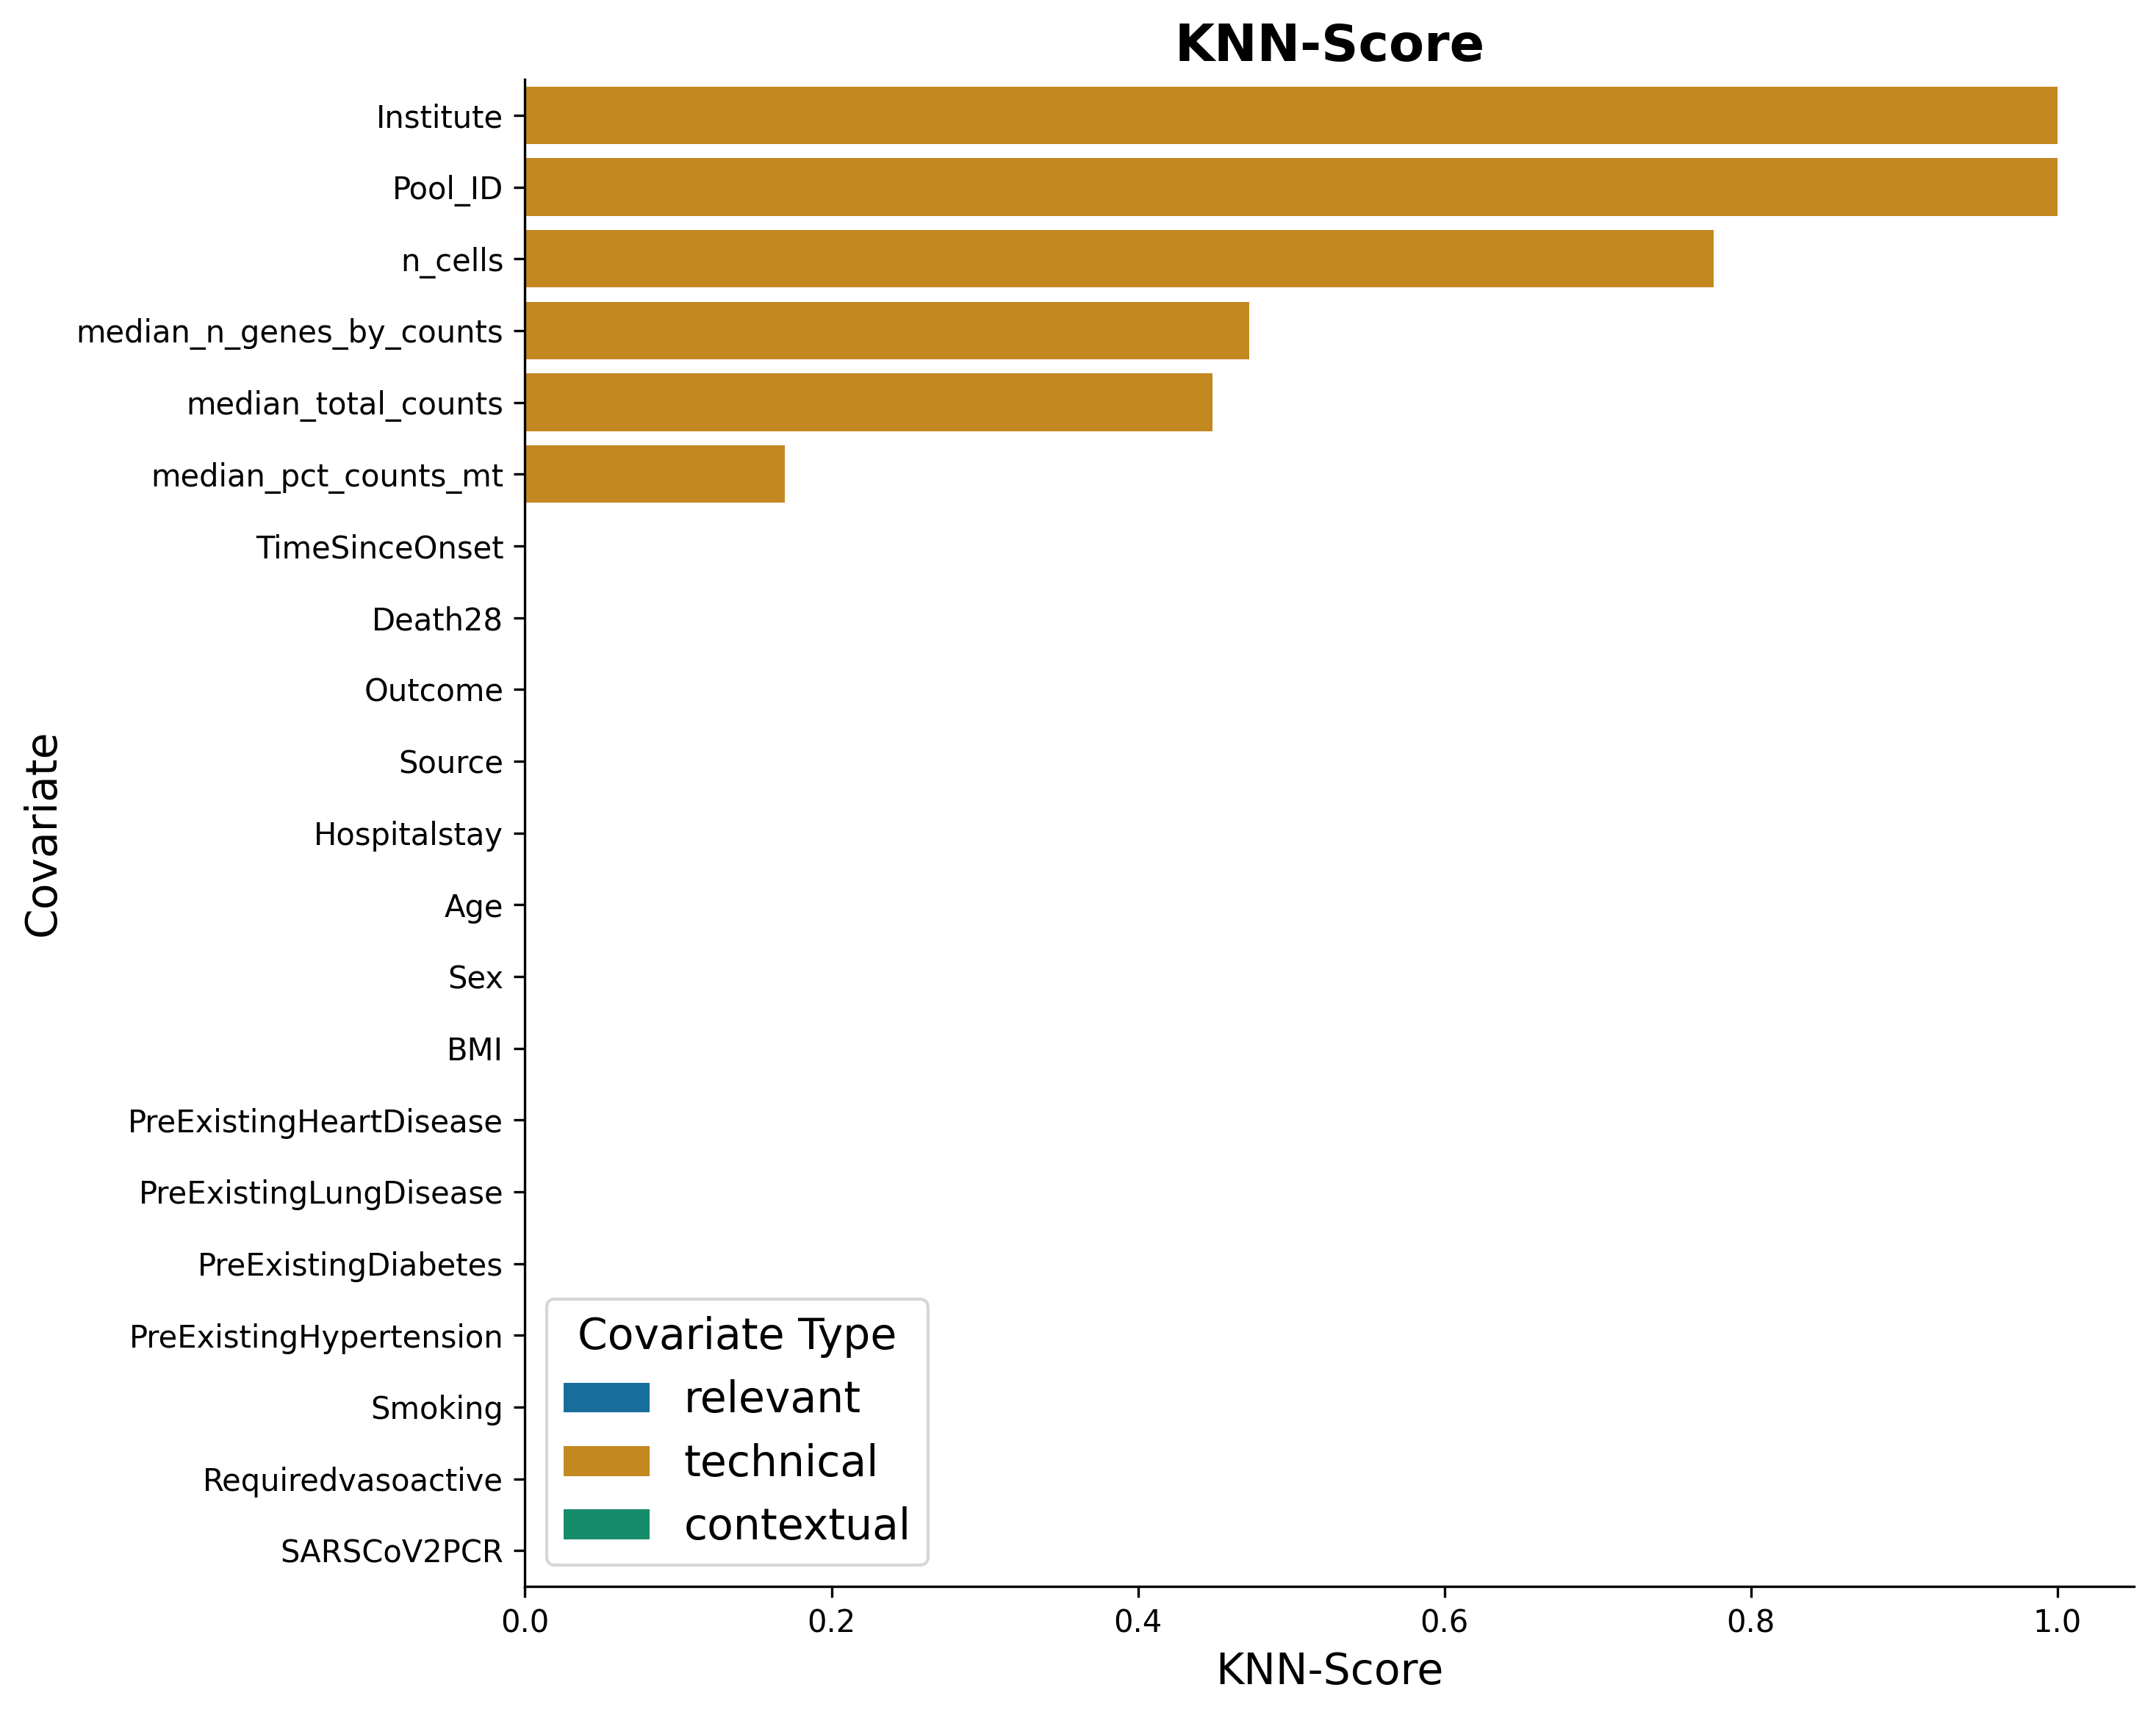

In [177]:
plt.figure(figsize=(10, 8), dpi=300)
plt.rcParams.update({
    'font.size': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

sns.barplot(
    data=knn_results,
    y="covariate",
    x="score",
    hue="covariate_type",
    dodge=False,
    palette="colorblind",
    order=knn_results.sort_values('score', ascending = False).covariate
)

plt.xlabel("KNN-Score")
plt.ylabel("Covariate")

plt.legend(title="Covariate Type")
plt.title("KNN-Score", fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()